# Ensemble model calibration using a spatiotemporal proxy for CO2 Monitoring
### Misael M. Morales, The University of Texas at Austin
Morales, M.M., Torres-Verdin, C., and Pyrcz, M. J. (2024). Ensemble model calibration and uncertainty quantification in geologic CO2 storage using a spatiotemporal deep learning proxy

In [1]:
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.linalg as sla
import scipy.optimize as sopt
#from pyswarms.single import GlobalBestPSO
from pyesmda import ESMDA

import torch
from neuralop.models import FNO

NREALIZATIONS = 500
NX, NY = 32, 32

In [2]:
def check_torch(verbose:bool=True):
    if torch.cuda.is_available():
        torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
        count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
        if verbose:
            print('-'*60)
            print('----------------------- VERSION INFO -----------------------')
            print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
            print('# Device(s) available: {}, Name(s): {}'.format(count, name))
            print('-'*60)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return device
    else:
        torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
        if verbose:
            print('-'*60)
            print('----------------------- VERSION INFO -----------------------')
            print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
            print('-'*60)
        device = torch.device('cpu')
        return device

device = check_torch(verbose=True)

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.3.1.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------


In [8]:
idx = np.load('tests/idx.npy')
mm, dd, uu = np.load('tests/features.npy'), np.load('tests/targets.npy'), np.load('tests/results/predictions.npy')
mm = (mm-mm.mean())/mm.std()
dd = (dd-dd.mean())/dd.std()
dd_, uu_ = np.expand_dims(dd,1), np.expand_dims(uu,1)
ee = 100 * sla.norm(dd_ - uu_, axis=1) / sla.norm(dd)
print('m: {} | d: {} | u: {} | e: {}'.format(mm.shape, dd.shape, uu.shape, ee.shape))
print('-'*30)
print('m - min: {:.4f} | max: {:.4f}  | mean: {:.4f} | std: {:.4f}'.format(mm.min(), mm.max(), mm.mean(), mm.std()))
print('d - min: {:.4f} | max: {:.4f}  | mean: {:.4f} | std: {:.4f}'.format(dd.min(), dd.max(), dd.mean(), dd.std()))
print('u - min: {:.4f} | max: {:.4f}  | mean: {:.4f}  | std: {:.4f}'.format(uu.min(), uu.max(), uu.mean(), uu.std()))
print('e - min: {:.1e} | max: {:.1e} | mean: {:.1e} | std: {:.1e}'.format(ee.min(), ee.max(), ee.mean(), ee.std()))

m: (500, 32, 32) | d: (500, 32, 32) | u: (500, 32, 32) | e: (500, 32, 32)
------------------------------
m - min: -4.1562 | max: 4.3722  | mean: -0.0000 | std: 1.0000
d - min: -4.2680 | max: 4.4268  | mean: -0.0000 | std: 1.0000
u - min: -4.2628 | max: 4.3386  | mean: 0.0143  | std: 1.0141
e - min: 4.5e-10 | max: 1.7e-01 | mean: 5.8e-03 | std: 7.0e-03


In [10]:
losses = pd.read_csv('tests/results/losses.csv')
metrics = pd.read_csv('tests/results/metrics.csv', index_col=0)
metrics.index = ['R2','MAPE','MSE','SSIM','PSNR']

fno = FNO(n_modes=(12,12), n_layers=4, norm='group_norm', use_mlp=True, mlp_dropout=0.1,
          in_channels=1, lifting_channels=256, hidden_channels=256, projection_channels=256, out_channels=1)
fno.load_state_dict(torch.load('tests/results/surrogate.pth', map_location='cpu'))
print('FNO # parameters: {:,}'.format(sum(p.numel() for p in fno.parameters() if p.requires_grad)))

FNO # parameters: 44,704,513


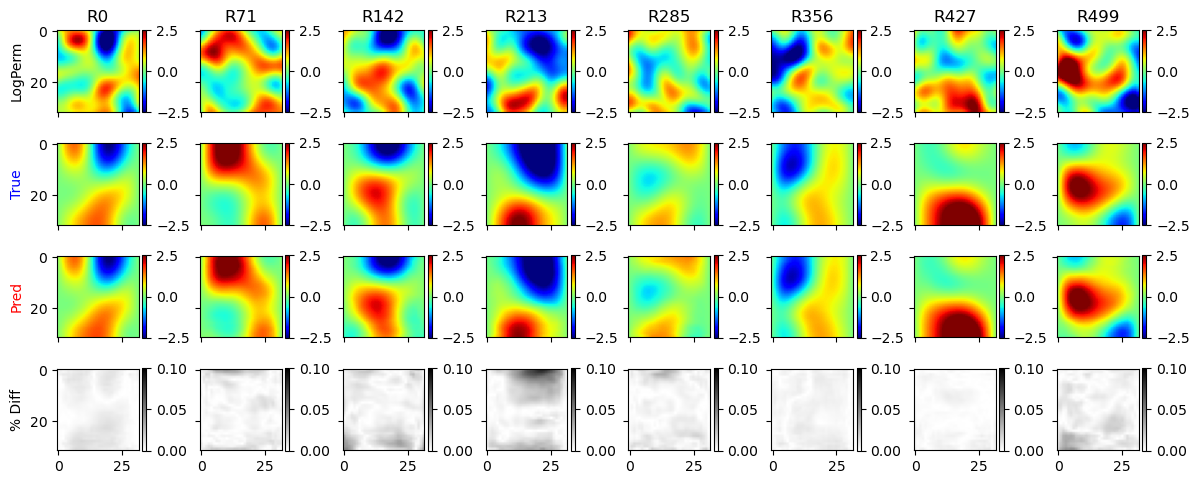

In [11]:
mult = 65
rshow = np.linspace(0, 499, num=8, dtype=int)
labs = ['LogPerm','True','Pred','% Diff']
hues = ['black','blue','red','black']

fig, axs = plt.subplots(4, 8, figsize=(12,5), sharex=True, sharey=True)
for j in range(8):
    k = rshow[j] #j*mult
    ax1, ax2, ax3, ax4 = axs[0,j], axs[1,j], axs[2,j], axs[3,j]
    ax1.set_title('R{}'.format(k))
    [a.set_ylabel(labs[i], color=hues[i]) for i,a in enumerate([ax1,ax2,ax3,ax4])] if j==0 else None
    im1 = ax1.imshow(mm[k], cmap='jet', vmin=-2.5, vmax=2.5)
    im2 = ax2.imshow(dd[k], cmap='jet', vmin=-2.5, vmax=2.5)
    im3 = ax3.imshow(uu[k], cmap='jet', vmin=-2.5, vmax=2.5)
    im4 = ax4.imshow(ee[k], cmap='binary', vmin=0, vmax=0.1)
    [plt.colorbar(i, pad=0.04, fraction=0.046) for i in [im1,im2,im3,im4]]
plt.tight_layout()
plt.show()

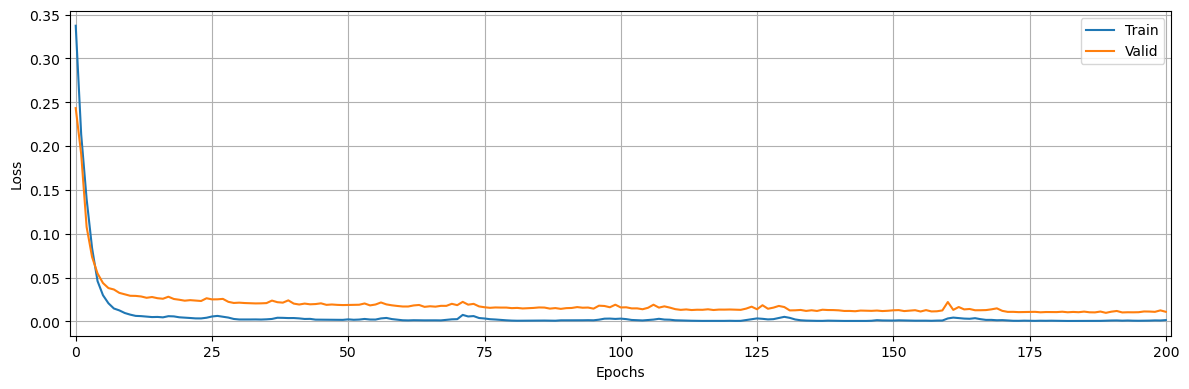

In [12]:
plt.figure(figsize=(12,4))
plt.plot(losses.index, losses['train'], label='Train', color='tab:blue')
plt.plot(losses.index, losses['valid'], label='Valid', color='tab:orange')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.xlim(-1,len(losses))
plt.legend(); plt.grid(True, which='both')
plt.tight_layout()
plt.show()

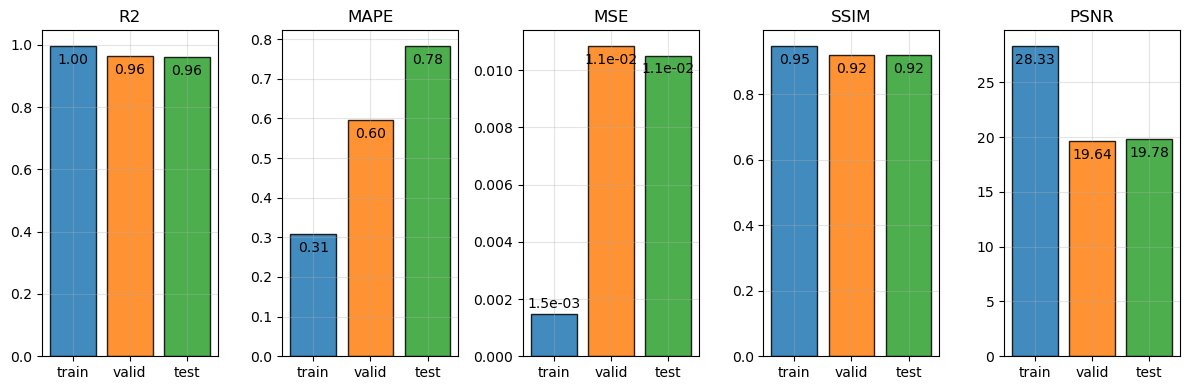

In [13]:
labs = ['train','valid','test']
hues = ['tab:blue','tab:orange','tab:green']
plt.figure(figsize=(12,4))
for i in range(len(metrics)):
    plt.subplot(1, len(metrics), i+1)
    for j in range(3):
        b = plt.bar(labs[j], metrics.iloc[i,j], alpha=0.85, color=hues[j], edgecolor='k', label=labs[j])
        plt.bar_label(b, padding=2 if b.datavalues<0.005 else -15, 
                      fmt='{:.2f}' if b.datavalues>0.02 else '{:.1e}')
    plt.grid(True, which='both', alpha=0.33)
    plt.title(metrics.index[i])
plt.tight_layout()
plt.show()

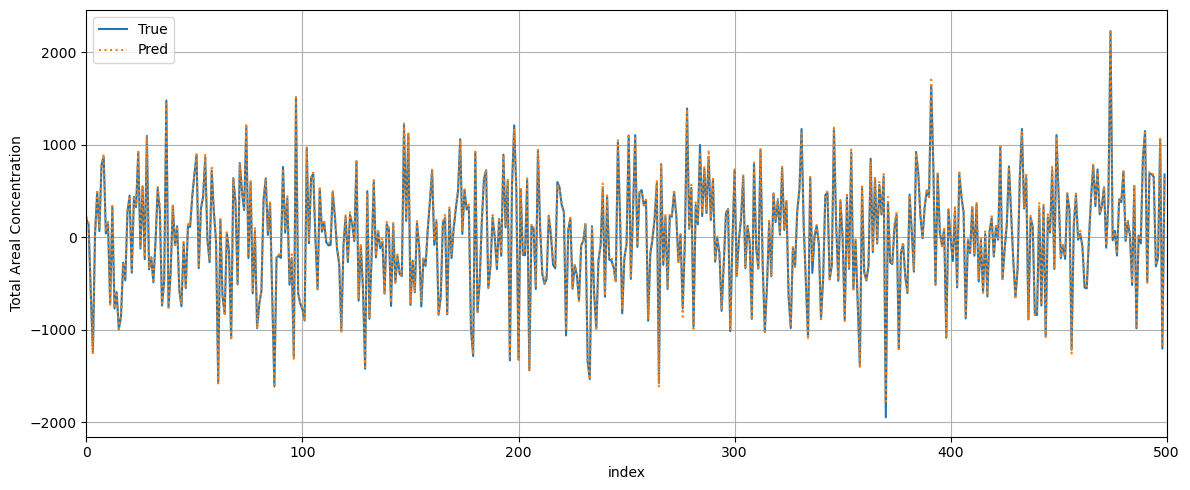

In [14]:
plt.figure(figsize=(12,5))
plt.plot(np.sum(dd, axis=(-2,-1)), ls='-', label='True')
plt.plot(np.sum(uu, axis=(-2,-1)), ls=':', label='Pred')
plt.xlabel('index'); plt.ylabel('Total Areal Concentration')
plt.xlim(0,500)
plt.legend(); plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [25]:
mm_true = np.expand_dims(mm[141], 0)
dd_obs = np.expand_dims(dd[141], 0).reshape(-1)

n_ensemble = 20
m_ensemble = mm[:n_ensemble].reshape(n_ensemble, -1)
print('Ground Truth: {} | Obs: {} | Ensemble: {}'.format(mm_true.shape, dd_obs.shape, m_ensemble.shape))

def forward_model(m_ensemble):
    m = torch.tensor(m_ensemble, dtype=torch.float32).view(m_ensemble.shape[0], 1, 32, 32)
    u = fno(m).detach().numpy().reshape(m_ensemble.shape[0], -1)
    return u

cov_obs = np.diag([1.0] * dd_obs.shape[0])
print('Cov_obs: {}'.format(cov_obs.shape))

n_assimilations = 4
cov_obs_inflation_geo = 1.2
cov_obs_inflation_factors: list[float] = [1.1]
for l in range(1, n_assimilations):
    cov_obs_inflation_factors.append(cov_obs_inflation_factors[l - 1] / cov_obs_inflation_geo)
scaling_factor: float = np.sum(1 / np.array(cov_obs_inflation_factors))
cov_obs_inflation_factors = [ alpha * scaling_factor for alpha in cov_obs_inflation_factors ]
cov_mm_inflation_factors: list[float] = [1.2] * n_assimilations

solver = ESMDA(
    dd_obs,
    m_ensemble,
    cov_obs,
    forward_model,
    n_assimilations           = n_assimilations,
    cov_obs_inflation_factors = cov_obs_inflation_factors,
    cov_mm_inflation_factors  = cov_mm_inflation_factors,
    save_ensembles_history    = True,
)
solver.solve()
m_posterior = solver.m_prior
d_posterior = solver.d_pred

Ground Truth: (1, 32, 32) | Obs: (1024,) | Ensemble: (20, 1024)
Cov_obs: (1024, 1024)
Assimilation # 1
Assimilation # 2
Assimilation # 3
Assimilation # 4


In [27]:
m_prior_mean = np.mean(m_ensemble, axis=0).reshape(32,32)
m_prior_stdv = np.std(m_ensemble, axis=0).reshape(32,32)

m_posterior_mean = np.mean(m_posterior, axis=0).reshape(32,32)
m_posterior_stdv = np.std(m_posterior, axis=0).reshape(32,32)

d_prior_mean = np.mean(solver.d_history[0], axis=0).reshape(32,32)
d_prior_stdv = np.std(solver.d_history[0], axis=0).reshape(32,32)

d_posterior_mean = np.mean(d_posterior, axis=0).reshape(32,32)
d_posterior_stdv = np.std(d_posterior, axis=0).reshape(32,32)

data = [[m_prior_mean, m_prior_stdv, d_prior_mean, d_prior_stdv],
        [m_posterior_mean, m_posterior_stdv, d_posterior_mean, d_posterior_stdv]]

labels = [['Mean(M_prior)', 'StDev(M_prior)', 'Mean(D_prior)', 'StDev(D_prior)'],
          ['Mean(M_posterior)', 'StDev(M_posterior)', 'Mean(D_posterior)', 'StDev(D_posterior)']]

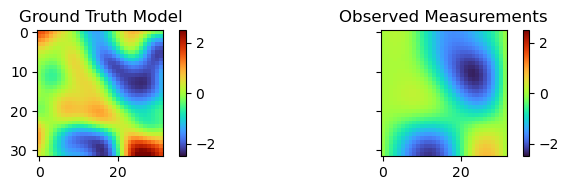

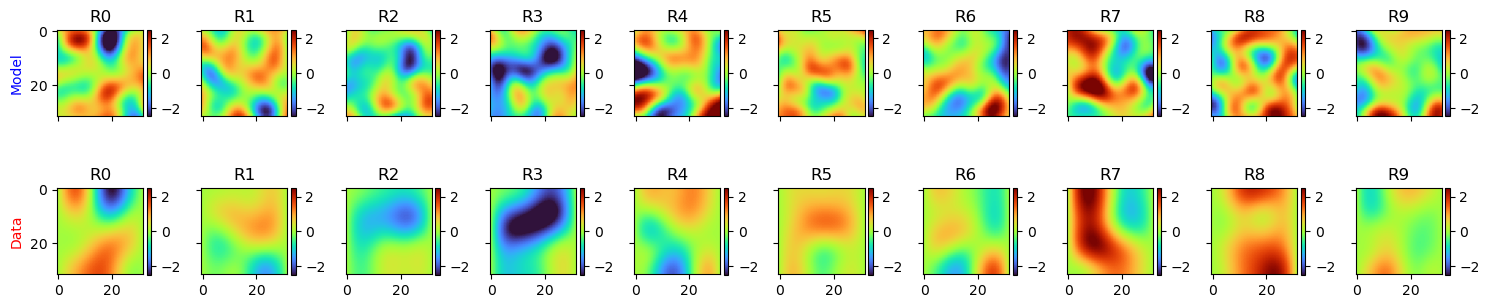

In [28]:
cmap, vmin, vmax = 'turbo', -2.5, 2.5

fig, axs = plt.subplots(1 ,2 ,figsize=(8,2), sharex=True, sharey=True)
for i in range(2):
    ax = axs[i]
    im = ax.imshow([mm_true, dd_obs][i].reshape(32,32), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, pad=0.04, fraction=0.046)
    ax.set_title(['Ground Truth Model','Observed Measurements'][i])
plt.tight_layout()
plt.show()

labs = ['Model','Data']
hues = ['blue','red']
fig, axs = plt.subplots(2, np.min([n_ensemble, 10]), figsize=(15,3.5), sharex=True, sharey=True)
for j in range(np.min([n_ensemble, 10])):
    ax1, ax2 = axs[0,j], axs[1,j]
    [a.set_title('R{}'.format(j)) for a in [ax1,ax2]]
    im1 = ax1.imshow(mm[j], cmap=cmap, vmin=vmin, vmax=vmax)
    im2 = ax2.imshow(dd[j], cmap=cmap, vmin=vmin, vmax=vmax)
    [a.set_ylabel(labs[k], color=hues[k]) for k,a in enumerate([ax1,ax2])] if j==0 else None
    [plt.colorbar(ii, pad=0.04, fraction=0.046) for ii in [im1,im2]]
plt.tight_layout()
plt.show()

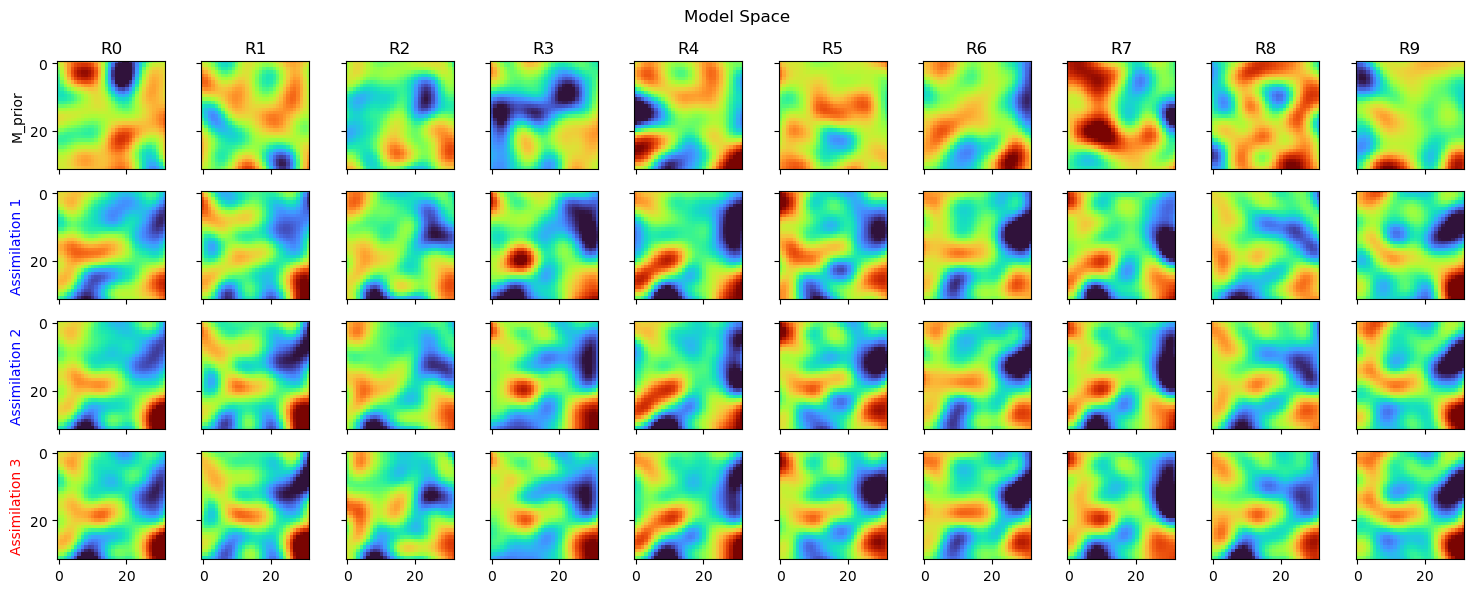

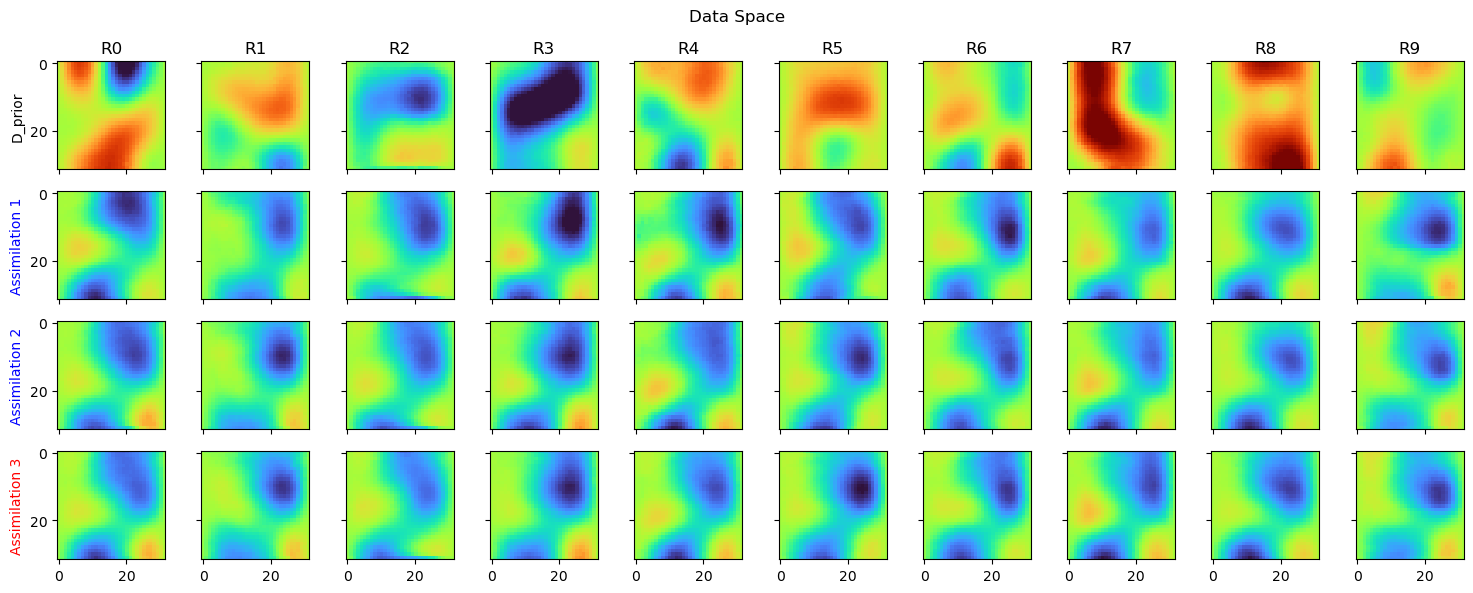

In [29]:
m_labels = ['M_prior', 'Assimilation 1', 'Assimilation 2', 'Assimilation 3']
d_labels = ['D_prior', 'Assimilation 1', 'Assimilation 2', 'Assimilation 3']
hues = ['black','blue','blue','red']
cmap, vmin, vmax = 'turbo', -2.5, 2.5

fig, axs = plt.subplots(4, np.min([n_ensemble, 10]), figsize=(15,6), sharex=True, sharey=True)
for i in range(4):
    for j in range(np.min([n_ensemble, 10])):
        ax = axs[i,j]
        ax.set_title('R{}'.format(j)) if i==0 else None
        ax.imshow(solver.m_history[i][j].reshape(32,32), cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_ylabel(m_labels[i], color=hues[i]) if j==0 else None
fig.suptitle('Model Space')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(4, np.min([n_ensemble, 10]), figsize=(15,6), sharex=True, sharey=True)
for i in range(4):
    for j in range(np.min([n_ensemble, 10])):
        ax = axs[i,j]
        ax.set_title('R{}'.format(j)) if i==0 else None
        ax.imshow(solver.d_history[i][j].reshape(32,32), cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_ylabel(d_labels[i], color=hues[i]) if j==0 else None
fig.suptitle('Data Space')
plt.tight_layout()
plt.show()

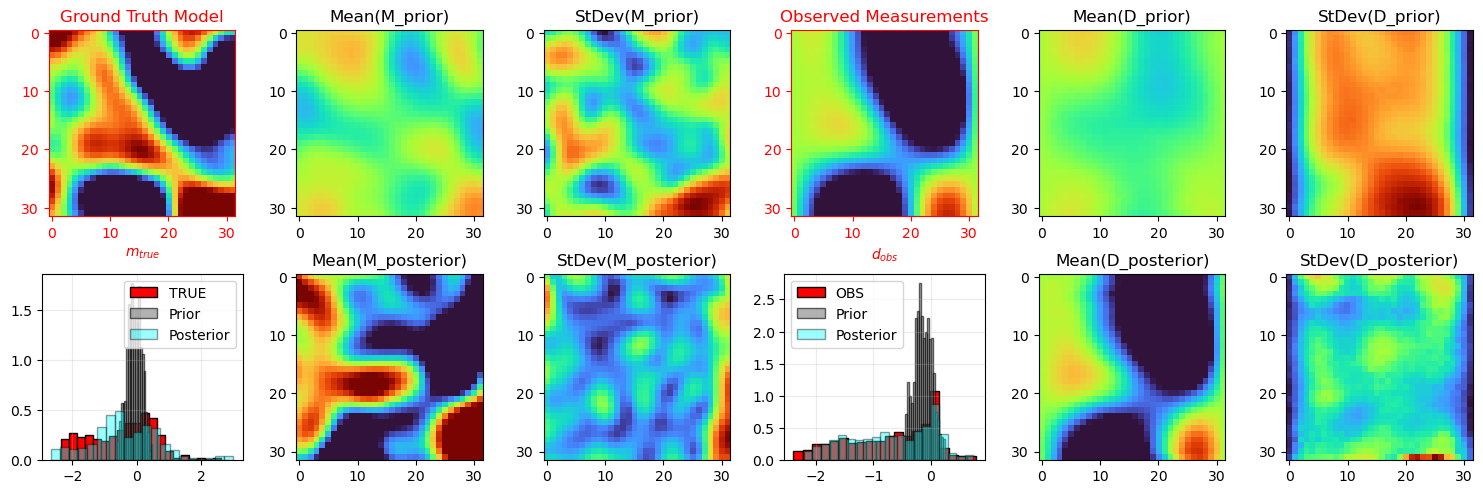

In [38]:
fig = plt.figure(figsize=(15,5))
gs  = GridSpec(2, 6, figure=fig)
cmap, vmin, vmax = 'turbo', -1, 1

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(mm_true.reshape(32,32), cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title('Ground Truth Model', color='r')
ax1.set_xlabel('$m_{true}$', color='r')
ax1.tick_params(colors='r')
[ax1.spines[a].set_color('r') for a in ['top','bottom','left','right']]
for i in range(2):
    for j in range(1,3):
        ax = fig.add_subplot(gs[i,j])
        ax.imshow(data[i][j-1], cmap=cmap, vmin=vmin if j<2 else None, vmax=vmax if j<2 else None)
        ax.set(title=labels[i][j-1])
ax2 = fig.add_subplot(gs[1,0])
ax2.hist(mm_true.flatten(), label='TRUE', bins=20, edgecolor='k', alpha=1, color='red', density=True)
ax2.hist(solver.m_history[0].mean(0), label='Prior', bins=20, edgecolor='k', alpha=0.6, color='gray', density=True)
ax2.hist(solver.m_history[-1].mean(0), label='Posterior', bins=20, edgecolor='k', alpha=0.4, color='cyan', density=True)
ax2.legend(); ax2.grid(True, which='both', alpha=0.25)

ax3 = fig.add_subplot(gs[0,3])
ax3.set_title('Observed Measurements', color='r')
ax3.set_xlabel('$d_{obs}$', color='r')
ax3.tick_params(colors='r')
[ax3.spines[a].set_color('r') for a in ['top','bottom','left','right']]
ax3.imshow(dd_obs.reshape(32,32), cmap=cmap, vmin=vmin, vmax=vmax)
for i in range(2):
    for j in range(4,6):
        ax = fig.add_subplot(gs[i,j])
        ax.imshow(data[i][j-2], cmap=cmap, vmin=vmin if j<5 else None, vmax=vmax if j<5 else None)
        ax.set(title=labels[i][j-2])
ax4 = fig.add_subplot(gs[1,3])
ax4.hist(dd_obs, label='OBS', bins=20, edgecolor='k', alpha=1, color='red', density=True)
ax4.hist(solver.d_history[0].mean(0), label='Prior', bins=20, edgecolor='k', alpha=0.6, color='gray', density=True)
ax4.hist(solver.d_history[-1].mean(0), label='Posterior', bins=20, edgecolor='k', alpha=0.4, color='cyan', density=True)
ax4.legend(); ax4.grid(True, which='both', alpha=0.25)

plt.tight_layout()
plt.show()

***
## Optimization

In [20]:
def testfun(d):
    xx, yy = d[0], d[1]
    u1 = xx**4 + yy**4
    u2 = -16*xx**2 - 16*yy**2
    u3 = 5*xx + 5*yy
    return (u1 + u2 + u3)/2

def constraint(d):
    xx, yy = d[0], d[1]
    return (xx**2 + yy**2)

In [22]:
xinit = [-1.0, -0.5]
bounds = [ [-5, 5], [-5, 5] ]
ineq = 24

In [23]:
npts = 250
xx, yy = np.meshgrid(np.linspace(bounds[0][0],bounds[0][1],npts), np.linspace(bounds[1][0],bounds[1][1],npts))
zz = np.ma.masked_where(constraint([xx,yy]) >= ineq, testfun([xx,yy]))

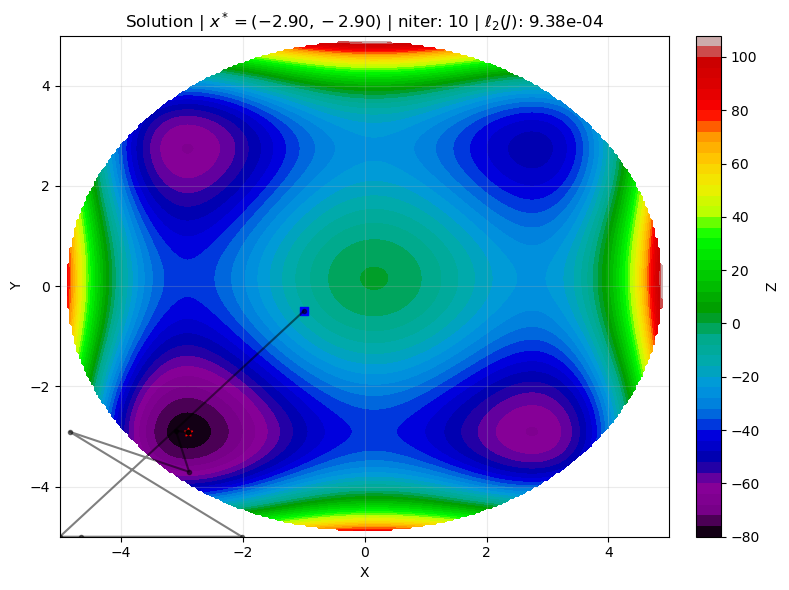

In [24]:
xhist = []
res = sopt.minimize(testfun,
                    x0          = xinit,
                    method      = 'SLSQP',
                    bounds      = bounds,
                    tol         = 1e-6,
                    callback    = lambda x: xhist.append(x),
                    constraints = sopt.NonlinearConstraint(constraint, 0, ineq),
                    options     = {'maxiter':1e3})
xhist = np.vstack([np.array(xinit), np.array(xhist)])

plt.figure(figsize=(8,6))

im = plt.contourf(xx, yy, zz, levels=50, cmap='nipy_spectral')
plt.plot(xhist[:,0], xhist[:,1], color='k', marker='.', alpha=0.5)
plt.scatter(xinit[0], xinit[1], color='b', marker='s')
plt.scatter(res.x[0], res.x[1], color='r', marker='*')

plt.xlabel('X'); plt.ylabel('Y')
plt.title('Solution | $x^*=({:.2f},{:.2f})$ | niter: {} | $\ell_2(J)$: {:.2e}'.format(res.x[0], res.x[1], len(xhist)-1, sla.norm(res.jac)))
plt.colorbar(im, pad=0.04, fraction=0.046, label='Z')
plt.grid(True, which='both', alpha=0.25)
plt.xlim(bounds[0]); plt.ylim(bounds[1])
plt.tight_layout()
plt.show()

In [ ]:
optimizer = GlobalBestPSO(2, 2, options={'c1':0.6, 'c2':0.25, 'w':0.85}, bounds=[(-5,-5),(5,5)], center=[(0,0),(0,0)])
sol = optimizer.optimize(testfun, iters=500, verbose=0)
shist = np.array(optimizer.pos_history)

plt.figure(figsize=(8,6))

im = plt.contourf(xx, yy, zz, levels=50, cmap='nipy_spectral')
plt.scatter(xinit[0], xinit[1], color='b', marker='s')
plt.scatter(shist[:,0], shist[:,1], c='w', marker='.', edgecolor='darkgrey')

plt.xlabel('X'); plt.ylabel('Y')
plt.colorbar(im, pad=0.04, fraction=0.046, label='Z')
plt.grid(True, which='both', alpha=0.25)
plt.xlim(bounds[0]); plt.ylim(bounds[1])
plt.tight_layout()
plt.show()

***
# END